In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
dataset_name = 'TCGA-OV'
df = pd.read_csv("../data/OV/"+dataset_name+"/"+dataset_name+"_data.csv")
df = df[['PROM1','PROM2','final_state','OS(d)']]

In [3]:
from lifelines.statistics import logrank_test
cutoffs = np.linspace(df['PROM2'].min()+0.1, df['PROM2'].max()-0.1, 100)  # Range of potential cutoffs
logrank_pvals = []  # Store the p-values for each cutoff

# Calculate the log-rank test p-value for each cutoff
for cutoff in cutoffs:
    df['exp_group'] = np.where(df['PROM2'] <= cutoff, 'low', 'high')
    
    # Perform the log-rank test to compare survival between the two groups
    results = logrank_test(df['OS(d)'][df['exp_group'] == 'low'],
                           df['OS(d)'][df['exp_group'] == 'high'],
                           event_observed_A=df['final_state'][df['exp_group'] == 'low'],
                           event_observed_B=df['final_state'][df['exp_group'] == 'high'])
    logrank_pvals.append(results.p_value)

# Find the cutoff with the smallest p-value (best separation)
best_cutoff = cutoffs[np.argmin(logrank_pvals)]
best_cutoff

101.61417171717171

In [5]:
# make sure 'OS(d)' column is int
df['OS(d)'] = pd.to_numeric(df['OS(d)'], errors='coerce')
# make sure 'final_state' column is int
df['final_state'] = df['final_state'].astype(int)
df['exp_group'] = df['exp_group'].astype(str)

In [6]:
df

,PROM1,PROM2,final_state,OS(d),exp_group
0,1.1163,7.0028,1,2621,low
1,1.1163,13.9069,1,2621,low
2,0.8823,7.0028,1,2621,low
3,0.8823,13.9069,1,2621,low
4,0.7281,82.6072,1,949,low
...,...,...,...,...,...
266,0.7960,14.5609,1,2648,low
267,0.2056,31.0689,1,84,low
268,0.1940,15.0706,1,351,low
269,1.9786,33.7066,1,787,low


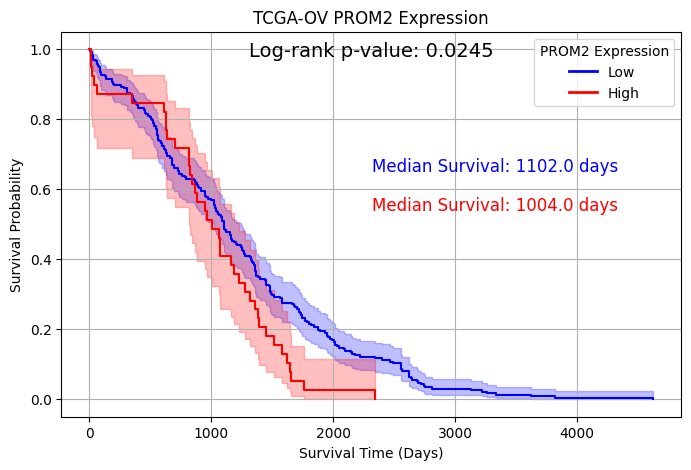

In [10]:
kmf = KaplanMeierFitter()
def plot_kaplan_meier(df, gene_column, gene_name, dataset_name):
    plt.figure(figsize=(8, 5))

    # log-rank test
    logrank_p_value = None
    low_color = 'blue'
    high_color = 'red'
    
    median_survival_time = []
    for group, color in zip(['low', 'high'], [low_color, high_color]):
        kmf.fit(df['OS(d)'][df[gene_column] == group], event_observed=df['final_state'][df[gene_column] == group], label=f'{gene_name} {group} Expression')
        kmf.plot_survival_function(color=color)

        median_survival_time.append(kmf.median_survival_time_)
    plt.text(0.7, 0.65, f'Median Survival: {median_survival_time[0]} days', ha='center', va='center', fontsize=12, color=low_color, transform=plt.gca().transAxes)
    plt.text(0.7, 0.55, f'Median Survival: {median_survival_time[1]} days', ha='center', va='center', fontsize=12, color=high_color, transform=plt.gca().transAxes)
       
    results = logrank_test(df['OS(d)'][df[gene_column] == 'high'],
                           df['OS(d)'][df[gene_column] == 'low'],
                           event_observed_A=df['final_state'][df[gene_column] == 'high'],
                           event_observed_B=df['final_state'][df[gene_column] == 'low'])
    logrank_p_value = results.p_value

    plt.text(0.5, 0.95, f'Log-rank p-value: {logrank_p_value:.4f}', ha='center', va='center', fontsize=14, color='black', transform=plt.gca().transAxes)

    # set the color
    legend_elements = [Line2D([0], [0], color=low_color, lw=2, label='Low'),
                       Line2D([0], [0], color=high_color, lw=2, label='High')]

    plt.title(f'{dataset_name} {gene_name} Expression')
    plt.xlabel('Survival Time (Days)')
    plt.ylabel('Survival Probability')
    plt.legend(handles=legend_elements, title=f'{gene_name} Expression')
    plt.grid(True)
#     plt.savefig('../pic/kaplan-meier/{}-{}.png'.format(dataset_name,gene_name)) 
    plt.show()

In [ ]:
def plot(gene):
    gene_median = df[gene].median()
    df['exp_group'] = np.where(df[gene] <= best_cutoff, 'low', 'high')
    plot_kaplan_meier(df, 'exp_group', gene, dataset_name)

plot('PROM2')